# Laboratorium 2 - wieloręcy bandyci

## Przygotowanie

 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab2`
 * zainstaluj potrzebne biblioteki:
 `pip3 install matplotlib`
 * upewnij się, że plik `bandit_framework.py` najduje się w tym samym katalogu

## Część 1. - framework i naiwni bandyci

In [114]:
%pip install matplotlib


[notice] A new release of pip is available: 23.1.2 -> 23.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [115]:
# importujemy wszystkie potrzebne pakiety
from copy import copy
from math import log, sqrt
from itertools import product
from random import betavariate, normalvariate, random, sample, shuffle, uniform
from bandit_framework import * # pakiet ze srodowiskiem testowym

In [116]:
# inicjalizujemy parametry testu

runs = 50
epochs = 100
recommendation_size = 10

In [117]:
# inicjalizujemy ramiona bandytow - payout każdego ramienia bedzie reprezentowany przez rozkład normalny
#   te ramiona dobrze reprezentują CTR, czyli funkcje celu o rozkładzie Bernoulliego
#   - mamy prawdopodobienstwo aktywacji (klikniecia) p i stały payout po kliknieciu
# Mozemy takze przygotowac inne typy ramion, np. z payoutem losowanym z rozkładu normalnego lub wykładniczego

good_arms = [Arm(f'good_{i}', uniform(0.5, 0.7), lambda: 1) for i in range(10)]
bad_arms = [Arm(f'bad_{i}', uniform(0.1, 0.4), lambda: 1) for i in range(90)]
arms = {arm.arm_id: arm for arm in good_arms+bad_arms}
arm_ids = list(arms.keys())

In [118]:
expected_highest_payout_per_epoch = sum(sorted([arm.activation_probability for arm in arms.values()], reverse=True)[:10])
print(f'Expected highest average payout per epoch: {expected_highest_payout_per_epoch}')

Expected highest average payout per epoch: 5.9873395225620545


In [119]:
# pierwszy bandyta - wybiera losowe ramiona

class Random(Bandit):
    def __init__(self, bandit_id, arm_ids):
        super().__init__(bandit_id, arm_ids)
    
    def recommend(self, size):
        return sample(self.arm_ids, size)
    
    def feedback(self, arm_id, payout):
        pass

In [120]:
# ten bandyta oszukuje - zna mozliwosci kazdego z ramion i wybiera najlepsze - przyda nam sie do porownania

class Perfect(Bandit):
    def __init__(self, bandit_id, arm_ids, arms):
        super().__init__(bandit_id, arm_ids)
        self.arms = arms
        self.expected_payouts = {}
        for arm in arms.values():
            self.expected_payouts[arm.arm_id] = self.__find_expected_value(arm.payout_function) * arm.activation_probability
        self.arm_ids_sorted_by_expected_payout = [x[0] for x in sorted(self.expected_payouts.items(), key=lambda x: x[1], reverse=True)]

    def recommend(self, size):
        return self.arm_ids_sorted_by_expected_payout[:size]
    
    def feedback(self, arm_id, payout):
        pass
    
    def __find_expected_value(self, payout_function, n=100000):
        # brzydka, ale skuteczna sztuczka, żeby metodą brute-force znaleźć wartość oczekiwaną
        return sum([payout_function() for i in range(n)]) / n

In [121]:
# tworzymy liste bandytow do przetestowania

bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]

In [122]:
# uruchamiamy test

runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect



Aggregated results:

perfect: 598.24
random: 283.30000000000007


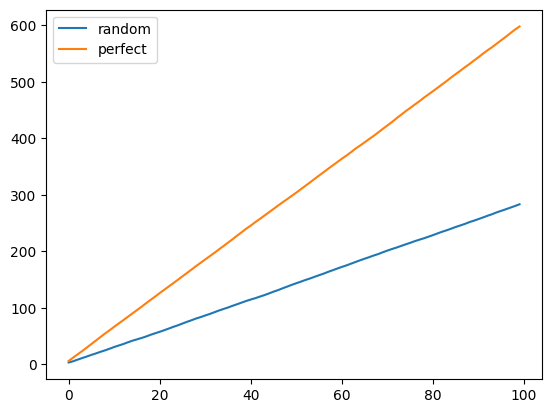

In [123]:
# wyniki sumaryczne dla wszystkich epok

runner.plot_results(results, runs, epochs, mode='cumulative')


Aggregated results:

perfect: 5.6
random: 3.06


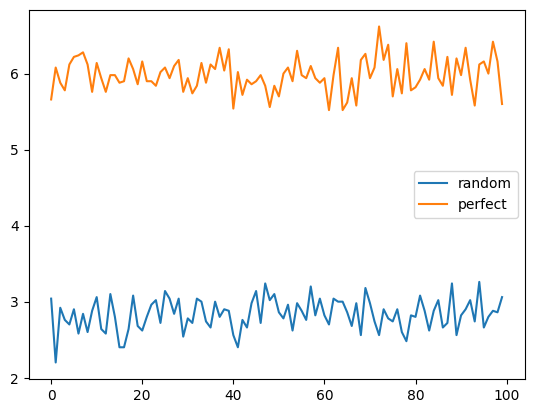

In [124]:
# wyniki per epoka

runner.plot_results(results, runs, epochs, mode='average')

## Część 2. - bandyci właściwi

In [125]:
class EGreedy(Bandit):
    def __init__(self, bandit_id, arm_ids, epsilon):
        super().__init__(bandit_id, arm_ids)
        self.epsilon = epsilon

        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
        
    
    def recommend(self, size):
        sorted_arm_ids = sorted(self.arm_ids, key=lambda x: self.payouts_per_recommendation[x], reverse=True)
        randomized_arm_ids = sorted_arm_ids[:size]
        shuffle(randomized_arm_ids)
        
        recommendation = []
        for i in range(size):
            x = uniform(0, 1)
            recommended_arm_id = 0
            
            if x > self.epsilon:
                recommended_arm_id = randomized_arm_ids[i]
            else:
                recommended_arm_id = sorted_arm_ids[i]

            recommendation.append(recommended_arm_id)
            self.recommended_rates[recommended_arm_id] += 1
            
        return recommendation
        
    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]

In [126]:
class UCB(Bandit):
    def __init__(self, bandit_id, arm_ids, optimism_weight):
        super().__init__(bandit_id, arm_ids)
        self.optimism_weight = optimism_weight

        # te zera w mianowniku mogą być problematyczne
        # - zastanów się, czy lepiej je obsługiwac w locie, czy zainicjalizować tę mapę wartościami niezerowymi
        self.recommended_rates = {arm_id: 1.0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
        self.n = 0
    
    def recommend(self, size):
        self.n = size
        payouts_with_optimism = {arm_id: self.payouts_per_recommendation[arm_id] + self._optimism(arm_id) for arm_id in self.arm_ids}
        sorted_arm_ids = sorted(payouts_with_optimism, key=lambda x: payouts_with_optimism[x], reverse=True)
        recommendation = sorted_arm_ids[:size]
        for recommended_arm_id in recommendation:
            self.n += 1
            self.recommended_rates[recommended_arm_id] += 1
        return recommendation
    
    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]

    def _optimism(self, arm):
        return self.optimism_weight * sqrt(2 * log(self.n) / self.recommended_rates[arm])

In [127]:
class ThompsonSampling(Bandit):
    def __init__(self, bandit_id, arm_ids, reward_multiplier, regret_multiplier):
        super().__init__(bandit_id, arm_ids)
        self.reward_multiplier = reward_multiplier
        self.regret_multiplier = regret_multiplier
        self.a = {arm_id: 1 for arm_id in arm_ids}
        self.b = {arm_id: 1 for arm_id in arm_ids}
    
    def recommend(self, size):
        return sorted(self.arm_ids, key=lambda arm_id: betavariate(self.a[arm_id], self.b[arm_id]), reverse=True)[:size]
    
    def feedback(self, arm_id, payout):
        reward = payout * self.reward_multiplier
        regret = max(1-payout, 0) * self.regret_multiplier
        self.a[arm_id] += reward
        self.b[arm_id] += regret

## Część 3. - zgrubne porównanie bandytów

In [128]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]
# nie wahaj sie wybrac innych wartosci parametrow bandytow
# bandits.extend([EGreedy('egreedy_%s' % epsilon, arm_ids, epsilon) for epsilon in [0.01, 0.05, 0.1, 0.25]])
# bandits.extend([UCB('ucb_%s' % optimism_weight, arm_ids, optimism_weight) for optimism_weight in [0.01, 0.1, 1, 10]])
bandits.extend([ThompsonSampling('ts_%s_%s' % (reward_weight, regret_weight), arm_ids, reward_weight, regret_weight)
                for reward_weight, regret_weight in product([1, 5, 10, 20, 50], [1, 5, 10, 20, 50])])

In [129]:
runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect
Simulating: ts_1_1
Simulating: ts_1_5
Simulating: ts_1_10
Simulating: ts_1_20
Simulating: ts_1_50
Simulating: ts_5_1
Simulating: ts_5_5
Simulating: ts_5_10
Simulating: ts_5_20
Simulating: ts_5_50
Simulating: ts_10_1
Simulating: ts_10_5
Simulating: ts_10_10
Simulating: ts_10_20
Simulating: ts_10_50
Simulating: ts_20_1
Simulating: ts_20_5
Simulating: ts_20_10
Simulating: ts_20_20
Simulating: ts_20_50
Simulating: ts_50_1
Simulating: ts_50_5
Simulating: ts_50_10
Simulating: ts_50_20
Simulating: ts_50_50



Aggregated results:

ts_10_20: 6.18
perfect: 6.08
ts_10_1: 6.02
ts_1_10: 6.0
ts_5_1: 5.96
ts_5_20: 5.96
ts_20_5: 5.92
ts_1_20: 5.9
ts_10_5: 5.9
ts_20_1: 5.9
ts_5_5: 5.88
ts_1_1: 5.86
ts_10_50: 5.72
ts_1_5: 5.68
ts_5_10: 5.64
ts_1_50: 5.6
ts_10_10: 5.36
ts_50_1: 5.32
ts_50_10: 5.32
ts_5_50: 5.22
ts_50_5: 5.22
ts_20_50: 5.16
ts_20_10: 4.98
ts_20_20: 4.8
ts_50_20: 4.68
ts_50_50: 3.98
random: 3.32


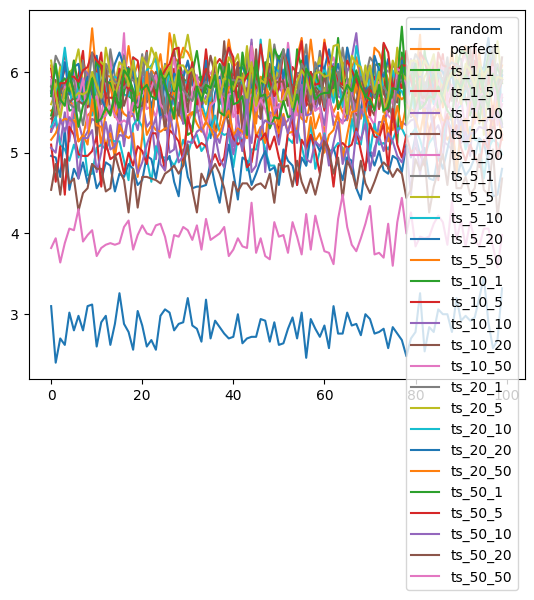

In [130]:
runner.plot_results(results, runs, epochs, mode='average')


Aggregated results:

perfect: 597.5000000000001
ts_10_5: 595.6799999999997
ts_5_5: 594.6600000000003
ts_20_5: 591.7400000000001
ts_5_1: 591.36
ts_5_20: 590.0399999999998
ts_10_1: 589.1600000000001
ts_20_1: 584.76
ts_1_5: 583.4399999999996
ts_5_10: 582.62
ts_1_50: 582.2399999999999
ts_1_10: 582.18
ts_1_1: 580.3199999999998
ts_1_20: 579.6800000000001
ts_10_20: 573.7399999999999
ts_50_1: 569.2200000000001
ts_10_50: 558.4600000000002
ts_5_50: 551.3000000000003
ts_10_10: 537.1799999999998
ts_20_50: 532.6400000000002
ts_50_10: 514.9200000000001
ts_20_10: 509.18000000000023
ts_50_5: 506.16000000000014
ts_20_20: 482.46000000000004
ts_50_20: 468.00000000000006
ts_50_50: 396.6199999999999
random: 284.79999999999995


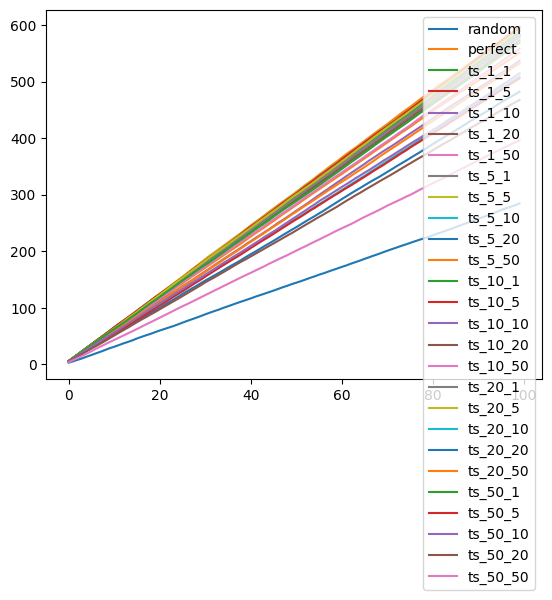

In [131]:
runner.plot_results(results, runs, epochs, mode='cumulative')

## Część 4. - dokładne porównanie bandytów

In [132]:
# obliczmy liste wszystkich dobrych ramion (arm_id zaczyna sie od 'good_') w rekomendacji
def relevant(recommendation: List[Arm]) -> int:
    return sum(1 for arm in recommendation if arm.arm_id.startswith('good_'))

all_relevant = relevant(arms.values())
all_relevant

10

In [133]:
# obliczmy precision@k i recall@k (zgodnie ze wzorami z wykladu)
def precision_at_k(recommendation: List[Arm], k: int) -> float:
    return relevant(recommendation) / k

def recall_at_k(recommendation: List[Arm], k: int, all_relevant: int) -> float:
    return relevant(recommendation) / all_relevant

In [134]:
# sprawdzmy, czy działa
sample_bandit = bandits[-1]
k = 3
recommendation_ids = sample_bandit.recommend(recommendation_size)
recommendation = [arms[arm_id] for arm_id in recommendation_ids]
print(f'Precision@{k} for bandit {sample_bandit.bandit_id}: {precision_at_k(recommendation, k)}')
print(f'Recall@{k} for bandit {sample_bandit.bandit_id}: {recall_at_k(recommendation, k, all_relevant)}')

Precision@3 for bandit ts_50_50: 0.6666666666666666
Recall@3 for bandit ts_50_50: 0.2


In [135]:
# wybieramy kilku istniejacych, wytrenowanych bandytow (perfect, random, po jednym e-greedy, UCB, TS)
testing_bandits = [
  Perfect('perfect', arm_ids, arms),
  Random('random', arm_ids),
  EGreedy('egreedy_0.05', arm_ids, 0.05),
  UCB('ucb_0.01', arm_ids, 0.01),
  TS('ts_5_5', arm_ids, 5, 5)
]
# wybieramy wartosci k do porownania
k_vals = [3, 5, 10]
# bedziemy liczyc sredni precision i recall dla `samples` rekomendacji
samples = 10

# dla kazdego bandyty - generujemy `samples` rekomendacji, liczymy precision i recall, wypisujemy srednie wartosci
# powtarzamy dla kazdego k
raise NotImplementedError()

NameError: name 'TS' is not defined